In [1]:
%pylab inline
fontsize = 20
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy import interpolate
from numpy.fft import fft, ifft, fftfreq
from time import time

from tqdm import trange
from best_subset import *
from solvel0 import solvel0

from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import normalize as sk_normalize

from findiff import FinDiff
from abess.linear import LinearRegression
from UBIC import fit_blr, UBIC, decreasing_values_indices

import warnings
warnings.filterwarnings("ignore")

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

def ssr2llf(ssr, nobs):
    nobs2 = nobs / 2.0
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    return llf

def log_like_value(prediction, ground):                                                                                                               
    nobs = float(ground.shape[0])
    ssr = np.sum(np.abs(ground - prediction)**2)
    return ssr2llf(ssr, nobs)

def BIC_AIC(prediction, ground, nparams, reg_func = lambda x: x):
    nparams = reg_func(nparams)
    llf = log_like_value(prediction, ground)
    return -2*llf + np.log(ground.shape[0])*nparams, -2*llf + 2*nparams

def rss2bic(rss, nparams, nobs, epsilon=1e-5):
    return nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*nparams

def AIC_Loss(As,bs,x,epsilon=1e-5):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    # Complexity
    k = np.count_nonzero(x)/m
    # AIC
    rss = [np.linalg.norm(bs[j] - As[j].dot(x[:,j].reshape(D,1)))**2 for j in range(m)]
    rss = np.sum(rss)
    return N*np.log(rss/N+epsilon) + 2*k + (2*k**2+2*k)/(N-k-1)

# Sensitivity to epsilon was never discussed!
def BIC_Loss(As,bs,x,epsilon=1e-5):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    # Complexity
    k = np.count_nonzero(x)/m
    # BIC
    res = np.vstack([bs[j] - As[j]@x[:, j:j+1] for j in range(m)])
    assert len(res) == n*m
    rss = np.linalg.norm(res, ord=2)**2 
    # llf = ssr2llf(rss, N)
    # -2*llf + np.log(N)*k # AIC: -2*llf + 2*k
    # N*np.log(2*np.pi*rss/N) + np.log(N)*k
    return N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*k

np.random.seed(1234)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv = a*(1+c*np.sin(t))*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u))
    return real(deriv)

In [3]:
# Set size of grid -> affect discovery results
n = 256
m = 256

# Set up grid
x = np.linspace(-8,8,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,10,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x+1)**2)

# Solve with time dependent uu_x term
params = (k, -1, 0.1, 0.25)
u = odeint(parametric_burgers_rhs, u0, t, args=(params,)).T # shape = (len(x), len(t))

u_xx_true = 0.1*np.ones(m)
uu_x_true = -1*(1+0.25*np.sin(t))

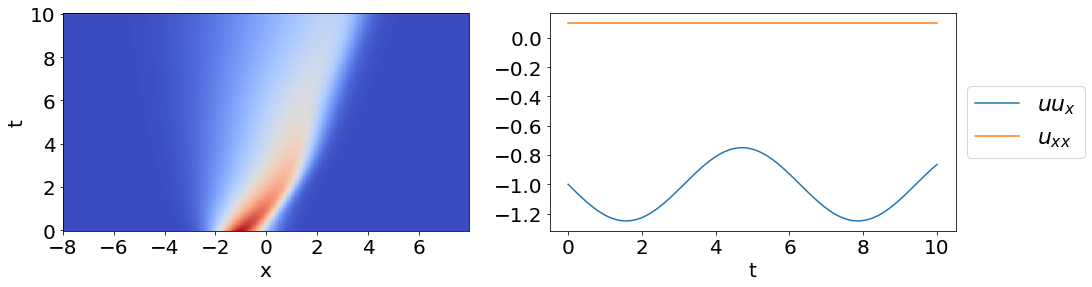

In [4]:
# Plot
fig=figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(t, uu_x_true, label=r'$uu_{x}$')
plot(t, u_xx_true, label=r'$u_{xx}$')

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('t', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [5]:
noise_lv = 10
noise_lv = abs(noise_lv)
u = u + 0.01*noise_lv*std(u)*np.random.randn(n, m)

if abs(noise_lv) > 0:
    print("Noisy", abs(noise_lv))
    # Build linear systems
    wx = 10 
    wt = 10 

    Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'poly', 
                                               deg_x = 6, deg_t = 4, 
                                               width_x = wx, width_t = wt)
    n = n - 2*wx
    m = m - 2*wt
    
else:
    print("Noiseless")
    Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'FD')

Noisy 10


In [6]:
def spatial_temporal_group(Theta, Ut, domain_shape, dependent="temporal"):
    n, m = domain_shape
    assert n*m == Theta.shape[0], Ut.shape[0]
    if dependent == "temporal":
        Theta_grouped = [(Theta[j*n:(j+1)*n,:]).real for j in range(m)]
        Ut_grouped = [(Ut[j*n:(j+1)*n]).real for j in range(m)]
    elif dependent == "spatial":
        Theta_grouped = [(Theta[n*np.arange(m)+j,:]).real for j in range(n)]
        Ut_grouped = [(Ut[n*np.arange(m)+j]).real for j in range(n)]
    else: return
    return Theta_grouped, Ut_grouped

def normalize_groups(As, bs, normalize=2):
    m = len(As)
    n,D = As[0].shape
    
    # get norm of each column
    candidate_norms = np.zeros(D)
    for i in range(D):
        candidate_norms[i] = Norm(np.vstack([A[:,i] for A in As]), normalize)

    norm_bs = [m*Norm(b, normalize) for b in bs]

    # normalize 
    for i in range(m):
        As[i] = As[i].dot(np.diag(candidate_norms**-1))
        bs[i] = bs[i]/norm_bs[i]
        
    return As, bs

In [7]:
# m = len(t); n = len(x)
# Theta_grouped = [real(Theta[j*n:(j+1)*n,:]) for j in range(m)]
# Ut_grouped = [real(Ut[j*n:(j+1)*n]) for j in range(m)]

Theta_grouped, Ut_grouped = spatial_temporal_group(Theta, Ut, (n, m), "temporal")

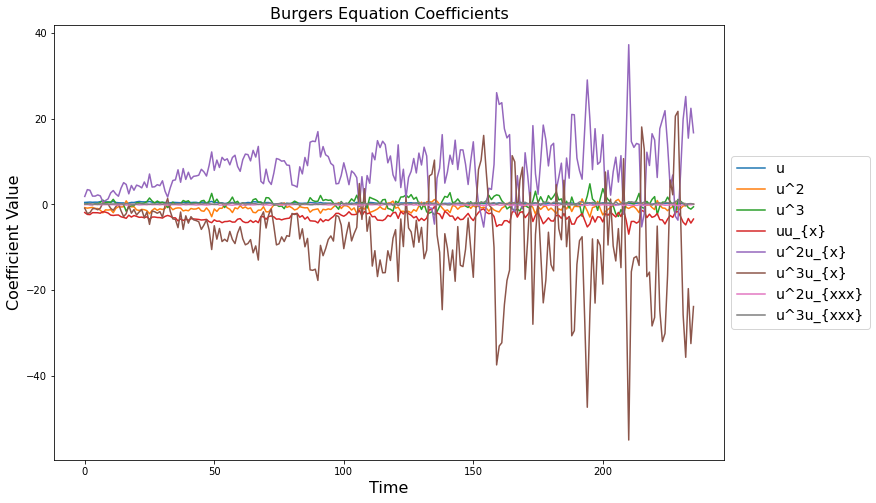

In [8]:
# sensitive to epsilon
# TrainSGTRidge -> not getting the optimal sol for each complexity > 2
# Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped, normalize=0) # Failed!
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped, normalize=2)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in np.where(np.linalg.norm(xi, axis=-1) > 1e-10)[0]:
    plot(xi[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

In [9]:
n_domain = 2500
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x], 
                                 function_names=[lambda x: x], 
                                 derivative_order=2, p=4, 
                                 spatiotemporal_grid=np.asarray(np.meshgrid(x, t)).T, 
                                 include_bias=False, is_uniform=True, K=n_domain
                                )
X_weak  = weak_pde_lib.fit_transform(np.expand_dims(u, -1))
y_weak = weak_pde_lib.convert_u_dot_integral(np.expand_dims(u, -1))
print(weak_pde_lib.get_feature_names())
bnb_gr_coeff = bnb(X_weak, y_weak, X_weak.shape[-1], corrected_coefficients=False)

# maximal_complexity = Theta_grouped[0].shape[-1]
# bnb_candidates = set()
# for i in trange(len(Theta_grouped)):
#     # Parallelize this line to speed up the code
#     bnb_sols = bnb(Theta_grouped[i], Ut_grouped[i], maximal_complexity, corrected_coefficients=False)
#     for j in range(bnb_sols.shape[1]):
#         indices = tuple(np.nonzero(bnb_sols[:, j:j+1])[0])
#         if indices not in bnb_candidates:
#             bnb_candidates.add(indices)

bnb_candidates = set(solvel0(X_weak, y_weak, max_complexity=X_weak.shape[-1], miosr=True, refine=True))
bnb_candidates

['x0', 'x0_1', 'x0_11', 'x0x0_1', 'x0x0_11']
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


{(0, 1, 2, 3, 4), (1, 2, 3), (1, 2, 3, 4), (2, 3), (3,)}

In [10]:
krr_bics = {}
kf = KFold(n_splits=5)
for i, (train_index, val_index) in enumerate(kf.split(X_weak)):
    X_train, y_train = X_weak[train_index, :], y_weak[train_index, :]
    X_val, y_val = X_weak[val_index, :], y_weak[val_index, :]
    for indices in bnb_candidates:
        krr = KernelRidge(kernel='rbf', alpha=0)
        krr.fit(X_train[:, indices], y_train)
        krr_bic = BIC_AIC(krr.predict(X_val[:, indices]), y_val, nparams=len(indices))[0]
        if tuple(indices) not in krr_bics:
            krr_bics[tuple(indices)] = krr_bic
        else:
            krr_bics[tuple(indices)] += krr_bic
print(krr_bics)

{(1, 2, 3): -21785.818176305642, (2, 3): -23392.368595383225, (1, 2, 3, 4): -22070.661834981547, (0, 1, 2, 3, 4): -20964.827214948913, (3,): -18889.45035360351}
